In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import glob
import os
from scipy import misc
import math

import gc
import timeit

In [2]:
for phase in glob.glob('data/phase*'):
    print(phase)

data/phase3
data/phase2
data/phase8
data/phase1
data/phase7
data/phase5
data/phase4
data/phase6


In [3]:
def one_hot(label, n_classes):
    one_hot = np.zeros(n_classes)
    one_hot[label] = 1
    return one_hot

In [4]:
'''
From traffic light msg
uint8 UNKNOWN=4
uint8 GREEN=2
uint8 YELLOW=1
uint8 RED=0
'''

state = {0: 'Red', 1: 'Yellow', 2: 'Green', 3: 'Unknown'}
paths = ['red/*.png', 'yellow/*.png', 'green/*.png', 'other/*.png']

n_labels = 4

X_all = []
y_all = []
hash_set = set()
for phase in glob.glob('data/phase*'):
    for i, path in enumerate(paths):
        for infile in glob.glob(phase+'/'+path):
            img = misc.imread(infile)
            # Scale modes: ‘nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’ or ‘cubic’
            for mode in ['cubic']:                
                img = misc.imresize(img, (32, 32), interp=mode)
                img_hash = hash(img.data.tobytes())
                if img_hash not in hash_set:
                    hash_set.add(img_hash)
                    X_all.append(img)
                    y_all.append(one_hot(i, n_labels))

X_all = np.array(X_all)
y_all = np.array(y_all)
print("{} images loaded with {} classes.".format(len(X_all), n_labels))

13504 images loaded with 4 classes.


In [5]:
X_all[0][0][0]

array([168, 201, 232], dtype=uint8)

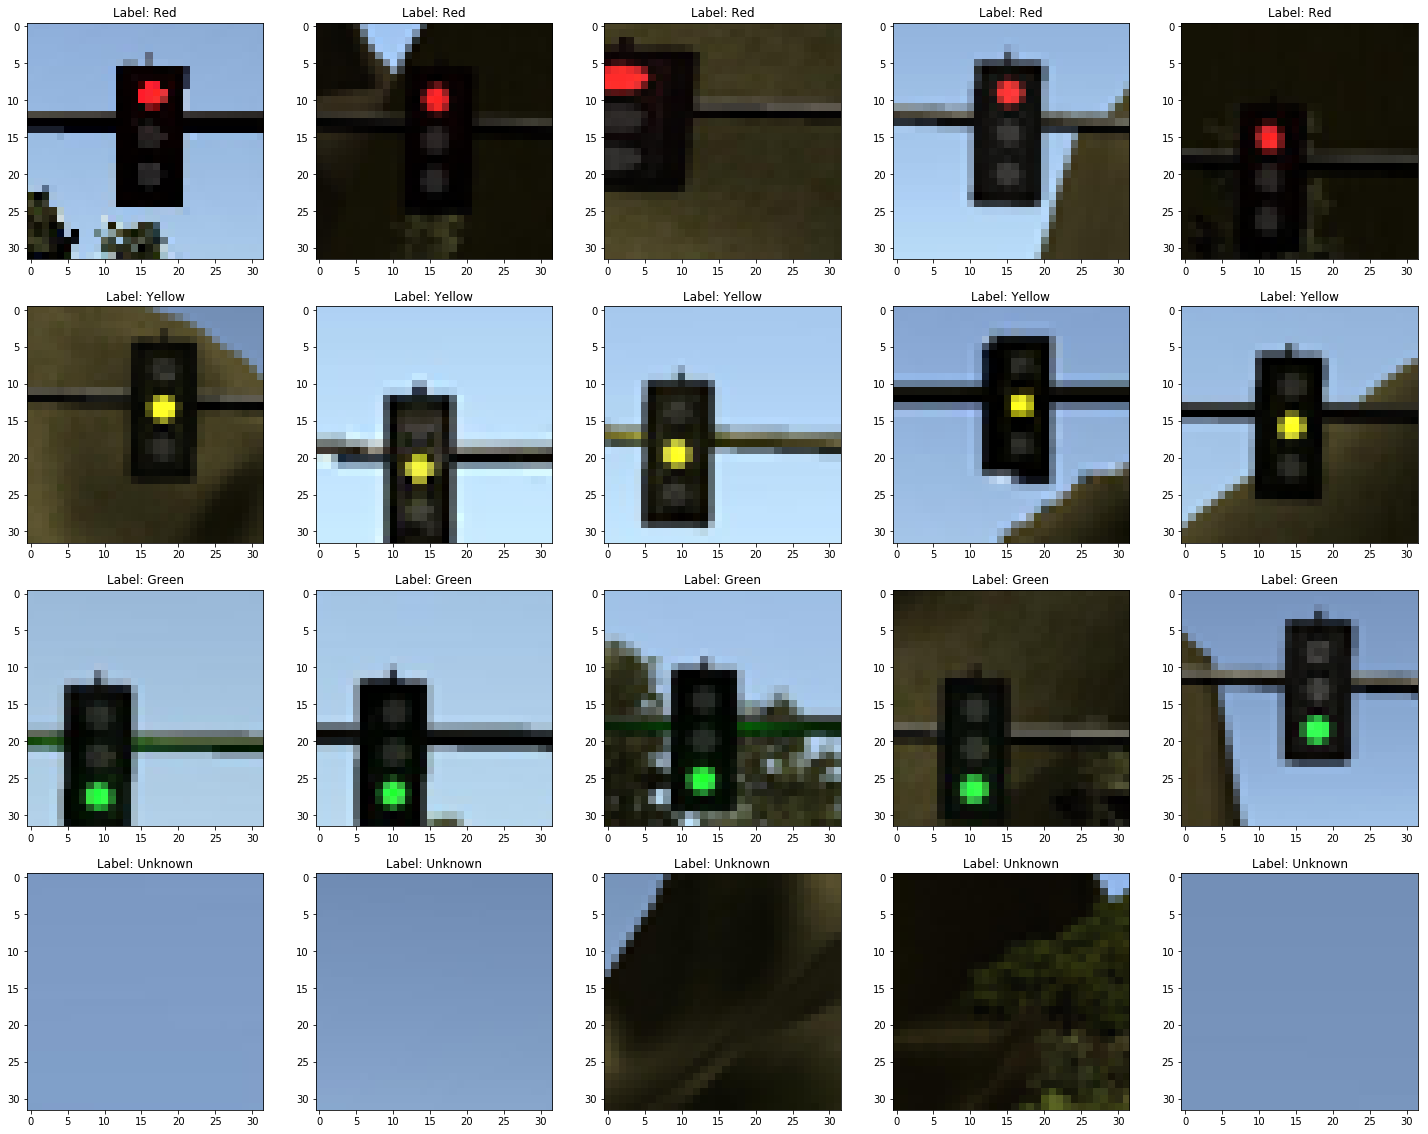

In [6]:
def show_data_examples(X, y, n_examples=5):
    plt.subplots(figsize=(5*n_examples, 5*n_labels))
    plt_index = 1
    for i  in range(len(y[0])):
        X_i = X[y[:,i] == 1]
        for img_index in np.random.randint(0, len(X_i), n_examples):
            plt.subplot(n_labels, n_examples, plt_index)
            plt.imshow(X_i[img_index])
            plt.title("Label: {}".format(state[i]))
            plt_index += 1
    plt.show()
show_data_examples(X_all, y_all)

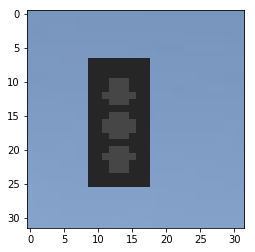

In [42]:
from skimage import draw

def draw_light(state, background):
    frame_ratio = 8/18  #w/h
    light_ratio = 1/4  #r/w
    
    img = np.copy(background)
    h, w, _ = np.shape(img)
    
    light_height = np.random.randint(0.5*h, 0.9*h)
    light_width = light_height*frame_ratio
    light_radius = light_width*light_ratio
    
    top = np.random.randint(0, h-light_height)
    left = np.random.randint(0, w-light_width)
    
    # Draw Rectangle
    y = [left, left+light_width, left+light_width, left]
    x = [top, top, top+light_height, top+light_height]
    
    rr, cc = draw.polygon(x, y, shape=img.shape)
    frame_color = np.random.randint(0, 60)
    img[rr, cc] = frame_color
    
    
    center_line = left+light_width//2
    off_color = np.random.randint(frame_color+20, 130)
    # Draw draw lights
    for i in range(3):
        rr, cc = draw.circle((i+1)/4*light_height+top, center_line, light_radius)
        if state == i:
            if state == 0:
                light_color = [np.random.randint(175,255), 
                               np.random.randint(0,80), 
                               np.random.randint(0,80)]
            elif state == 1:
                light_color = [np.random.randint(175,255), 
                               np.random.randint(175,255), 
                               np.random.randint(0,80)]
            elif state == 2:
                light_color = [np.random.randint(0,80), 
                               np.random.randint(175,255), 
                               np.random.randint(0,80)]
            else:
                light_color = off_color
        else:
            light_color = off_color
        img[rr, cc] = light_color
    
    return img
    
backgrounds = X_all[np.argmax(y_all, axis=1) == 3]
    
img = draw_light(3, backgrounds[2])
plt.imshow(img)
plt.show()

In [12]:
def gen_artifical_data(path='data/phase*/other/*png', n_augment=1):
    X = []
    y = []
    for infile in glob.glob(path):
        background = misc.imread(infile)
        for i in range(n_augment):
            for state in range(4):
                img = draw_light(state, background)
                img = misc.imresize(img, (32, 32), interp='cubic')
                X.append(img)
                y.append(one_hot(state, 4))
    return np.array(X), np.array(y)

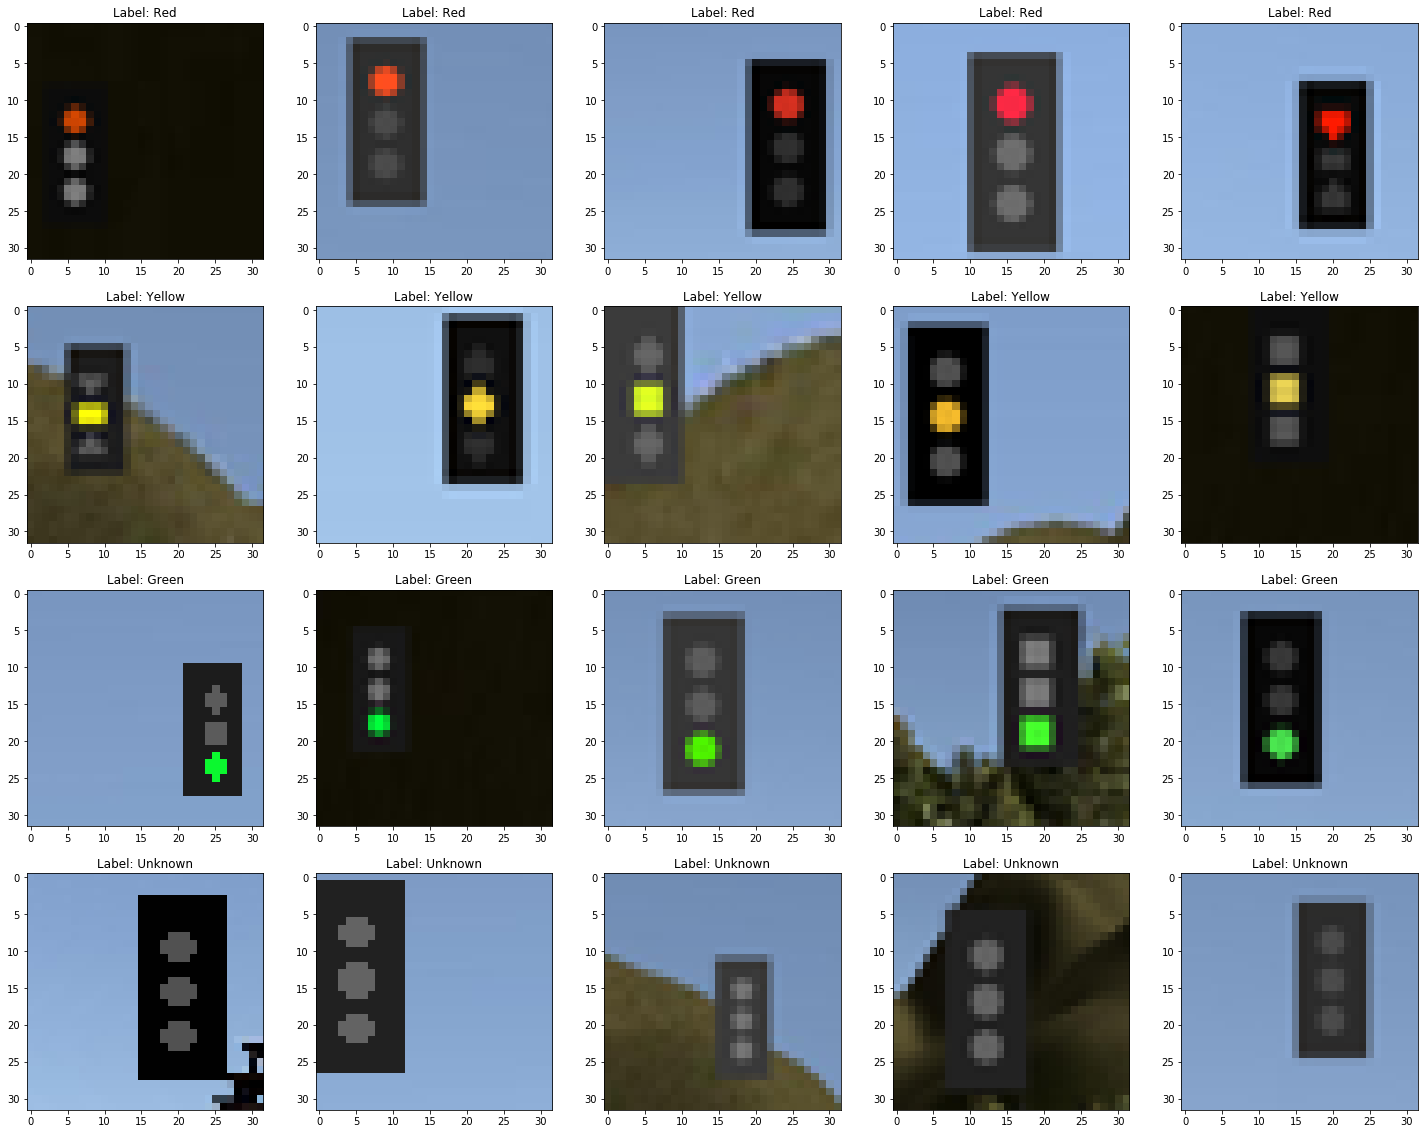

In [13]:
# Augment with artifial lights
X_art, y_art = gen_artifical_data(path='data/phase*/other/*png', n_augment=2)
show_data_examples(X_art, y_art)

In [14]:
# combine real and artifical data

X_all = np.concatenate([X_all, X_art])
y_all = np.concatenate([y_all, y_art])

In [15]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.10, random_state=121)
print("Train Size: {}".format(len(y_train)))
print("Test Size: {}".format(len(y_test)))

Train Size: 40579
Test Size: 4509


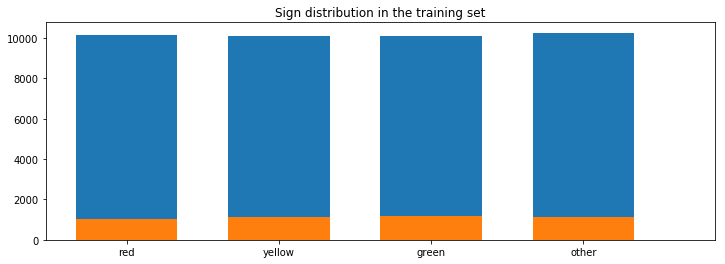

In [16]:
# Look at the distribution of training signs
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = plt.subplot(111)
width = 0.5
ax.hist(np.argmax(y_train, axis=1), bins=n_labels, width=width)
ax.hist(np.argmax(y_test, axis=1), bins=n_labels, width=width)
ax.set_xticks([0.25,1,1.75,2.5])
ax.set_xticklabels(['red', 'yellow', 'green', 'other'], rotation=0)
plt.title("Sign distribution in the training set")
plt.show()

In [17]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [26]:
def simple_FCN():
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(12, (3, 3),
                     strides=1,
                     padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))

    # Conv layer 2
    model.add(Conv2D(6, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Conv layer 3
    model.add(Conv2D(num_classes, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Global max pool to output
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))
    return model


def compress_FCN():
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(32, (3, 3),
                     strides=1,
                     padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    
    # Pool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    # Conv layer 2
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Pool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    # Conv layer 3
    model.add(Conv2D(num_classes, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Global max pool to output
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))
    return model

def CNN():
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(32, (3, 3),
                     strides=1,
                     padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    
    # Pool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    # Conv layer 2
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Pool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    # Conv layer 3
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Pool layer 3
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    # FC layers
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))

    model.add(Activation('softmax'))
    return model

In [27]:
batch_size = 10
num_classes = n_labels
epochs = 30
data_augmentation = True
early_stop = True
patience = 2
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'trained_model.h5'

# The data, shuffled and split between train and test sets:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print("Batch size: {}".format(batch_size))
print("Epochs: {}".format(epochs))
if early_stop:
    print("Early stop with patience of {}".format(patience))

# call model
# model = simple_FCN()
# model = compress_FCN()
model = CNN()

# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

# Compile traininer with loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    
    # Setup early stopping on validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    
    # Fit
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=[early_stopping])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Setup early stopping on validation loss
    if early_stop:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        workers=4,
                        callbacks=[early_stopping])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (40579, 32, 32, 3)
40579 train samples
4509 test samples
Batch size: 10
Epochs: 30
Early stop with patience of 2
Using real-time data augmentation.
Epoch 1/30
4057/4057 [==============================] - 35s - loss: 2.9880 - acc: 0.2785 - val_loss: 1.0871 - val_acc: 0.5491
Epoch 2/30
4057/4057 [==============================] - 33s - loss: 0.6651 - acc: 0.7538 - val_loss: 0.1950 - val_acc: 0.9925
Epoch 3/30
4057/4057 [==============================] - 33s - loss: 0.1255 - acc: 0.9744 - val_loss: 0.0123 - val_acc: 0.9984
Epoch 4/30
4057/4057 [==============================] - 33s - loss: 0.0401 - acc: 0.9916 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 5/30
4057/4057 [==============================] - 33s - loss: 0.0228 - acc: 0.9953 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 6/30
4057/4057 [==============================] - 33s - loss: 0.0198 - acc: 0.9960 - val_loss: 0.0020 - val_acc: 0.9998
Epoch 7/30
4057/4057 [==============================] - 33s - loss: 0.0167 - acc:

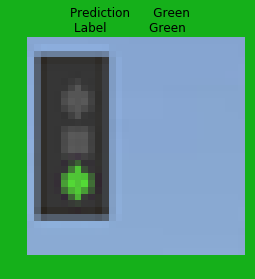

In [28]:
index = np.random.randint(0, len(X_all))
img = X_all[index]
prediction = np.argmax(model.predict(np.array([img])))
label = np.argmax(y_all[index])
if prediction == label:
    plt.figure(facecolor='xkcd:green')
else:
    plt.figure(facecolor='xkcd:red')
plt.imshow(img)
plt.title("{:15} {:8}\n{:15} {:8}".format("Prediction", state[prediction], "Label", state[label]))
plt.axis('off')
plt.show()

In [21]:
gc.collect()

4777

In [6]:
from keras.models import load_model
import numpy as np
    
# model = load_model('saved_models/trained_model.h5')
model = load_model('saved_models/CNN_trained_model.h5')
img = X_all[0]
np.argmax(model.predict(np.array([img])))

Using TensorFlow backend.


0

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0         
__________

In [30]:
from timeit import Timer

def predict(images):
        return model.predict(images)

def get_images(n):
    index_list = np.random.randint(0, len(X_all), n)
    images = []
    labels = []
    for i in index_list:
        images.append(X_all[i])
        labels.append(y_all[i])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    

# first argument is the code to be run, the second "setup" argument is only run once,
# and it not included in the execution time.
t = Timer('predict(images)', setup='from __main__ import predict, get_images; images, _ = get_images(100)')
# t = Timer('predict(images, 100)')

n = 200
time = t.timeit(n)
print("{:6.5f}".format(time))
# timeit.timeit('char in text', setup='text = "sample string"; char = "g"')

1.93223


2.00407     4 layer with final conv 3x3 to num classes
2.00286     3 layer with final conv 3x3 to num classes
1.91434     3 layer 16->8->num_classes
1.49570     48x48 img to 32x32 image
1.47931     32x32 img to 24x24 image

In [31]:
images = X_all
labels = y_all
conf = predict(images)
pred = np.argmax(conf, axis=1)
correct = np.argmax(labels, axis=1) == pred

labels = np.argmax(labels, axis=1)

print("{:4.3}% Correct".format(100*len(correct[correct==True])/len(correct)))
wrong = np.where(correct==False)
n_wrong = len(wrong[0])
print("{} wrong out of {}".format(n_wrong, len(images)))

99.9% Correct
25 wrong out of 45088


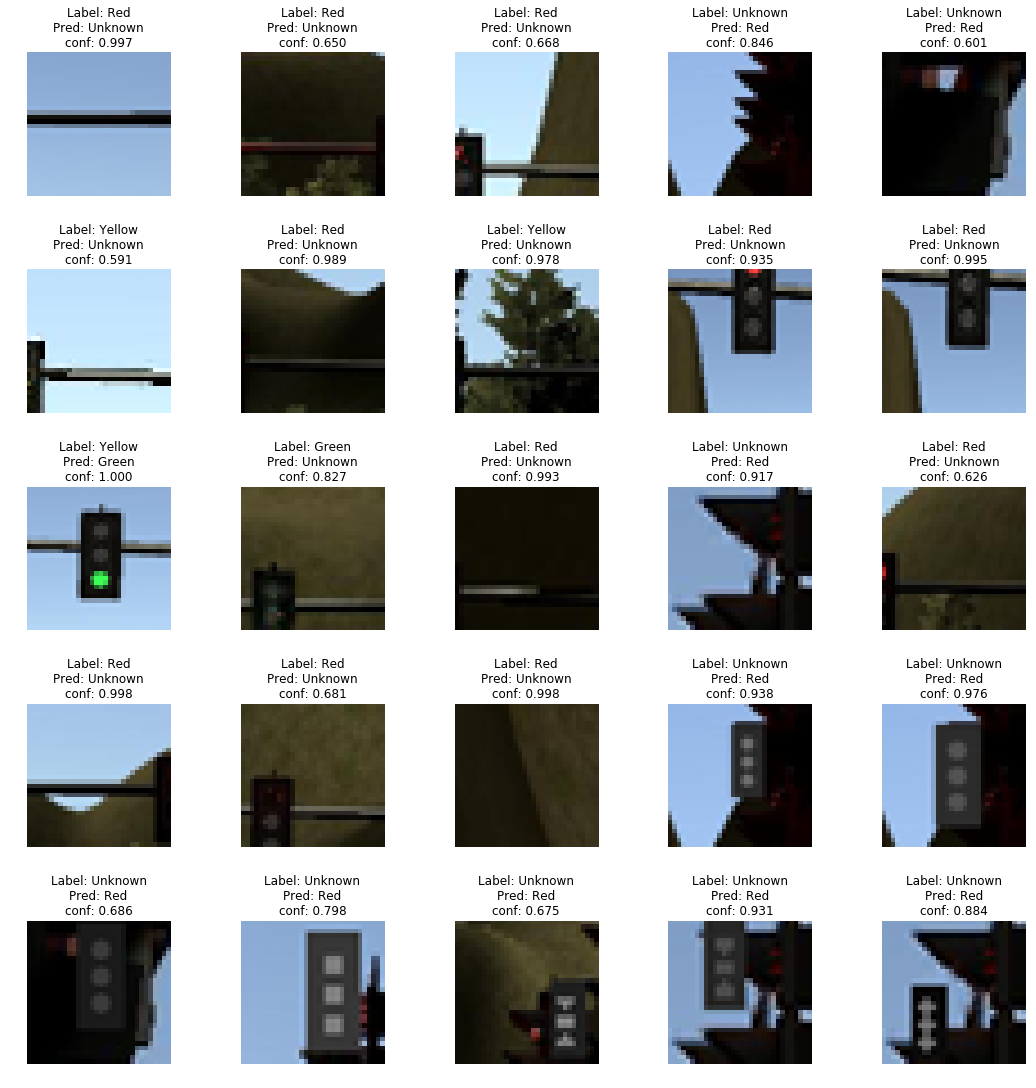

In [32]:
cols = 5
rows = n_wrong//cols+1
plt.subplots(figsize=(3*cols,3*rows))
i = 1
for i, (img, l, p, c) in enumerate(zip(images[wrong], labels[wrong], pred[wrong], conf[wrong])):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title("Label: {}\nPred: {}\nconf: {:.3f}".format(state[l], state[p], c[p]))
    plt.axis('off')
plt.tight_layout()
plt.show()